In [2]:
import numpy as np
import scipy
from scipy import special
import time
from copy import copy
import re
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import pandas as pd

In [23]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

# Используемые классы и функции

In [25]:
def accuracy(y_true, y_pred):
    length = len(y_true)
    true_classes = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            true_classes += 1
    return true_classes / length

In [26]:
class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """
    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')


class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.

    Оракул должен поддерживать l2 регуляризацию.
    """

    def __init__(self, l2_coef):
        """
        Задание параметров оракула.

        l2_coef - коэффициент l2 регуляризации
        """
        self.coef = l2_coef

    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """
        M = y * (X @ w)
        res = np.sum(np.logaddexp(0, -M)) / X.shape[0] + self.coef * (w.dot(w.T)) / 2
        return res

    def grad(self, X, y, w):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """
        if isinstance(X, np.ndarray):
            M = -y * (X.dot(w))
            denom = scipy.special.expit(M).reshape(-1, 1)
            res = -np.sum(X * y.reshape(-1, 1) * denom, axis=0).reshape(-1) / X.shape[0]
            res += self.coef * w
            return res
        if isinstance(X, scipy.sparse.csr_matrix):
            M = -y * (X.dot(w))
            denom = scipy.special.expit(M).reshape(-1,1)
            res = -np.sum(X.multiply(y.reshape(-1, 1)).multiply(denom),axis=0) / X.shape[0]
            res += self.coef * w
            return np.ravel(res)

In [27]:
class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
        self, loss_function, step_alpha=1, step_beta=0,
        tolerance=1e-5, max_iter=1000, **kwargs
    ):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора.
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия

        step_alpha - float, параметр выбора шага из текста задания

        step_beta- float, параметр выбора шага из текста задания

        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход

        max_iter - максимальное число итераций

        **kwargs - аргументы, необходимые для инициализации
        """
        self.loss_func = loss_function
        self.alpha = step_alpha
        self.beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.kwargs = kwargs

    def fit(self, X, y, X_test=None, y_test=None, w_0=None, trace=False, accur=False):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w_0 - начальное приближение в методе

        trace - переменная типа bool

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)

        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        history = {'time': [0.0], 'func': [], 'help_time': [0.0]} 
        if accur:
          history['accuracy'] = [0.0]
        if w_0 is None:
            cur_w0 = np.zeros(X.shape[1])
        else:
            cur_w0 = w_0
        if self.loss_func == 'binary_logistic':
            self.oracle = BinaryLogistic(**self.kwargs)
        history['func'].append(self.oracle.func(X, y, cur_w0))

        prev_time = time.time()
        prev_loss = history['func'][0]
        cur_w = cur_w0

        for i in range(self.max_iter):
            new_time = time.time()

            eta = self.alpha / ((i + 1) ** self.beta)
            cur_w = cur_w - (eta * self.oracle.grad(X, y, cur_w))
            self.w = copy(cur_w)
            cur_loss = self.oracle.func(X, y, cur_w)
            if accur:
                y_pred = self.predict(X_test)
                acc = accuracy(y_pred, y_test)
                history['accuracy'].append(acc)
            history['time'].append(new_time - prev_time)
            history['help_time'].append(history['help_time'][-1] + history['time'][-1])
            history['func'].append(cur_loss)
            
            if abs(prev_loss - cur_loss) < self.tolerance:
                break
            prev_time = copy(new_time)
            prev_loss = copy(cur_loss)
        self.w = cur_w
        if trace:
            return history

    def predict(self, X):
        """
        Получение меток ответов на выборке X

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        return: одномерный numpy array с предсказаниями
        """
        res = np.sign(X.dot(self.w))
        res[res == 0] = np.random.choice([-1,1], size=len(res[res == 0]))
        return res

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k
        """
        prob1 = scipy.special.expit(X.dot(self.w))
        prob2 = 1 - prob1
        return np.array((prob1.T, prob2.T)).T

    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: float
        """
        return self.oracle.func(X, y, self.w)

    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: numpy array, размерность зависит от задачи
        """
        return self.oracle.grad(X, y, self.w)

    def get_weights(self):
        """
        Получение значения весов функционала
        """
        return self.w

In [28]:
class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
        self, loss_function, batch_size, step_alpha=1, step_beta=0,
        tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs
    ):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора.
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия

        batch_size - размер подвыборки, по которой считается градиент

        step_alpha - float, параметр выбора шага из текста задания

        step_beta- float, параметр выбора шага из текста задания

        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход

        max_iter - максимальное число итераций (эпох)

        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.

        **kwargs - аргументы, необходимые для инициализации
        """
        self.loss_func = loss_function
        self.batch_size = batch_size
        self.alpha = step_alpha
        self.beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_seed = random_seed
        self.kwargs = kwargs

    def fit(self, X, y, w_0=None, trace=False, log_freq=1, accur=False, X_test=None, y_test=None):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w_0 - начальное приближение в методе

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}

        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления.
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.

        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """
        np.random.seed(self.random_seed)
        history = {'epoch_num': [0.0], 'time': [0.0], 'func': [], 'weights_diff': [0.0], 'help_time': [0.0]}
        if accur:
            history['accuracy'] = [0.0]

        if w_0 is None:
            cur_w0 = np.zeros(X.shape[1])
        else:
            cur_w0 = w_0

        if self.loss_func == 'binary_logistic':
            self.oracle = BinaryLogistic(self.kwargs['l2_coef'])
        history['func'].append(self.oracle.func(X, y, cur_w0))

        prev_time = time.time()
        prev_loss = history['func'][0]
        w_in_dict = copy(cur_w0)

        cur_loss = None
        cur_epoch = None
        cur_w = copy(cur_w0)

        objects = 0
        flag = False

        for i in range(self.max_iter):
            self.indexes = np.arange(X.shape[0])
            np.random.shuffle(self.indexes)
            for j in range(0, X.shape[0], self.batch_size):
                new_time = time.time()
                eta = self.alpha / ((i + 1) ** self.beta)
                if j + self.batch_size < X.shape[0]:
                    cur_indexes = self.indexes[j:j + self.batch_size]
                    objects += self.batch_size
                else:
                    cur_indexes = self.indexes[j:X.shape[0]]
                    objects += X.shape[0] - j

                cur_epoch = objects / X.shape[0]
                cur_w -= (eta * self.oracle.grad(X[cur_indexes], y[cur_indexes], cur_w))
                self.w = copy(cur_w)
                cur_loss = self.oracle.func(X[cur_indexes], y[cur_indexes], cur_w)
                if abs(cur_epoch - history['epoch_num'][-1]) > log_freq:
                    history['time'].append(new_time - prev_time)
                    history['help_time'].append(history['help_time'][-1] + history['time'][-1])
                    history['epoch_num'].append(cur_epoch)
                    history['weights_diff'].append((cur_w - w_in_dict) @ (cur_w - w_in_dict).T)
                    history['func'].append(cur_loss)
                    if accur:
                        y_pred = self.predict(X_test)
                        acc = accuracy(y_pred, y_test)
                        history['accuracy'].append(acc)
                    w_in_dict = copy(cur_w)

                if abs(prev_loss - cur_loss) < self.tolerance:
                    break
                    flag = True
                prev_time = copy(new_time)
                prev_loss = copy(cur_loss)
            if flag:
                break

        self.w = cur_w
        if trace:
            return history

# Предобработка

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
Train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_train.csv')

In [ ]:
Train['comment_text'] = Train['comment_text'].apply(lambda s: s.lower())
Train

,Unnamed: 0,comment_text,is_toxic
0,0,explanation\nwhy the edits made under my usern...,False
1,1,d'aww! he matches this background colour i'm s...,False
2,2,"hey man, i'm really not trying to edit war. it...",False
3,3,"""\nmore\ni can't make any real suggestions on ...",False
4,4,"you, sir, are my hero. any chance you remember...",False
...,...,...,...
52056,159494,"""\n\n our previous conversation \n\nyou fuckin...",True
52057,159514,you are a mischievious pubic hair,True
52058,159541,your absurd edits \n\nyour absurd edits on gre...,True
52059,159546,"""\n\nhey listen don't you ever!!!! delete my e...",True


In [ ]:
Train['comment_text'] = Train['comment_text'].apply(lambda s: re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', s))
Train

,Unnamed: 0,comment_text,is_toxic
0,0,explanation why the edits made under my userna...,False
1,1,d aww he matches this background colour i m s...,False
2,2,hey man i m really not trying to edit war it...,False
3,3,more i can t make any real suggestions on im...,False
4,4,you sir are my hero any chance you remember...,False
...,...,...,...
52056,159494,our previous conversation you fucking sh...,True
52057,159514,you are a mischievious pubic hair,True
52058,159541,your absurd edits your absurd edits on great...,True
52059,159546,hey listen don t you ever delete my edi...,True


In [ ]:
Y_train = copy(Train['is_toxic'])
Train = Train.drop('is_toxic', axis=1)

In [ ]:
Test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_test.csv')
Test['comment_text'] = Test['comment_text'].apply(lambda s: s.lower())
Test['comment_text'] = Test['comment_text'].apply(lambda s: re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', s))
Y_test = copy(Test['is_toxic'])
Test = Test.drop('is_toxic', axis=1)
Test

,Unnamed: 0,comment_text
0,0,thank you for understanding i think very high...
1,1,dear god this site is horrible
2,2,somebody will invariably try to add relig...
3,3,it says it right there that it is a type ...
4,4,before adding a new product to the lis...
...,...,...
20671,63877,nigel is a crazy idiot
20672,63935,well now don t i feel stupid
20673,63945,fourth baldrick possibly being cleverer than...
20674,63962,iran that s right iran it was o...


In [ ]:
cv = CountVectorizer(min_df=0.0001)

In [ ]:
Train = cv.fit_transform(Train['comment_text'])

In [ ]:
Train

<52061x16050 sparse matrix of type '<class 'numpy.int64'>'
	with 1996148 stored elements in Compressed Sparse Row format>

In [ ]:
Test = copy(cv.transform(Test['comment_text']))

In [ ]:
Test

<20676x16050 sparse matrix of type '<class 'numpy.int64'>'
	with 699626 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Train, Y_train, test_size=0.3, random_state=10)

In [ ]:
X_test

<15619x16050 sparse matrix of type '<class 'numpy.int64'>'
	with 598259 stored elements in Compressed Sparse Row format>

In [ ]:
y_test = y_test.values.astype(int) * 2 - 1

In [ ]:
y_train = y_train.values.astype(int) * 2 -1

In [ ]:
y_train

array([ 1, -1, -1, ..., -1,  1, -1])

# Исследование градиентного спуска

In [ ]:
alphas = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5]

In [ ]:
value_alpha_loss_time = list(range(6))
for i in range(6):
    value_alpha_loss_time[i] = {'loss':[], 'time':[], 'accuracy':[]}
    model = GDClassifier(loss_function='binary_logistic', step_alpha=alphas[i], step_beta=0.1, tolerance=1e-4, max_iter=150, l2_coef=0.01)
    history = model.fit(X_train, y_train, X_test=X_test, y_test=y_test, trace=True, accur=True)
    value_alpha_loss_time[i]['loss'] = copy(history['func'])
    value_alpha_loss_time[i]['time'] = copy(history['help_time'])
    value_alpha_loss_time[i]['accuracy'] = copy(history['accuracy'])
    

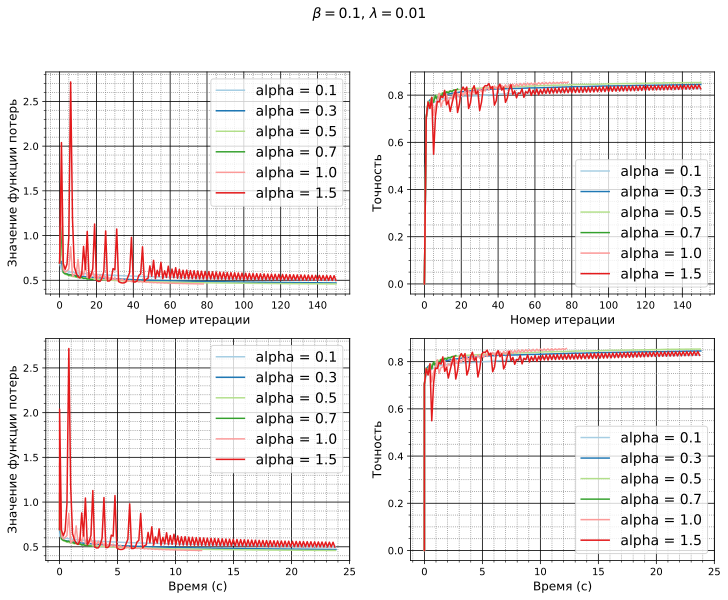

In [ ]:
fig = plt.figure(figsize=(12,9))
sns.set_palette("Paired")
fig.suptitle(r'$\beta=0.1$, $\lambda=0.01$', fontsize=14)
ax = fig.add_subplot(221)
plt.xlabel('Номер итерации', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(np.arange(len(value_alpha_loss_time[i]['loss'])), value_alpha_loss_time[i]['loss'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(222)
plt.xlabel('Номер итерации', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(np.arange(len(value_alpha_loss_time[i]['accuracy'])), value_alpha_loss_time[i]['accuracy'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(223)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(value_alpha_loss_time[i]['time'], value_alpha_loss_time[i]['loss'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(224)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(value_alpha_loss_time[i]['time'], value_alpha_loss_time[i]['accuracy'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)
plt.savefig('g_alpha_05_001.pdf')

In [ ]:
betas = [0.0, 0.1, 0.5, 0.8, 1.0, 1.2]

In [ ]:
value_beta_loss_time = list(range(6))
for i in range(6):
    value_beta_loss_time[i] = {'loss':[], 'time':[], 'accuracy':[]}
    model = GDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=betas[i], tolerance=1e-4, max_iter=150, l2_coef=0.01)
    history_beta = model.fit(X_train, y_train, X_test=X_test, y_test=y_test, trace=True, accur=True)
    value_beta_loss_time[i]['loss'] = copy(history_beta['func'])
    value_beta_loss_time[i]['time'] = copy(history_beta['help_time'])
    value_beta_loss_time[i]['accuracy'] = copy(history_beta['accuracy'])

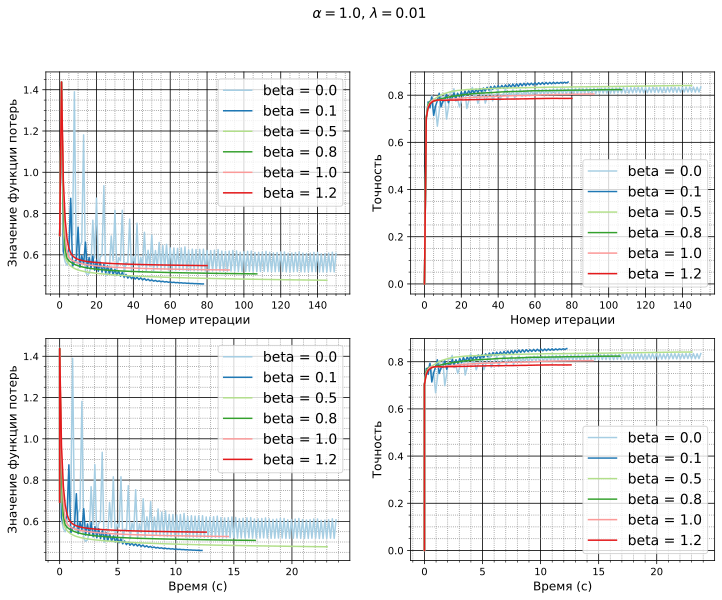

In [ ]:
fig = plt.figure(figsize=(12,9))
fig.suptitle(r'$\alpha=1.0$, $\lambda=0.01$', fontsize=14)
ax = fig.add_subplot(221)
plt.xlabel('Номер итерации', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(np.arange(len(value_beta_loss_time[i]['loss'])), value_beta_loss_time[i]['loss'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(222)
plt.xlabel('Номер итерации', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(np.arange(len(value_beta_loss_time[i]['accuracy'])), value_beta_loss_time[i]['accuracy'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(223)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(value_beta_loss_time[i]['time'], value_beta_loss_time[i]['loss'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(224)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(value_beta_loss_time[i]['time'], value_beta_loss_time[i]['accuracy'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)
plt.savefig('g_beta_01_001.pdf')

In [ ]:
 w0 = []
 w0.append(np.random.normal(size=X_train.shape[1]))
 w0.append(np.random.geometric(p=0.5, size=X_train.shape[1]).astype('float64'))
 w0.append(np.zeros(X_train.shape[1]))
 w0.append(np.ones(X_train.shape[1]))
 w0.append(np.random.uniform(size=X_train.shape[1]))

In [ ]:
for w in w0:
  print(w)

[-0.56472734  0.35467978 -0.36394636 ...  0.4454525  -0.57197685
 -1.05770563]
[2 1 1 ... 5 2 2]
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
[0.60275873 0.35241299 0.30880661 ... 0.32331776 0.69864016 0.88982962]


In [ ]:
value_w0_loss_time = list(range(5))
for i in range(5):
    value_w0_loss_time[i] = {'loss':[], 'time':[], 'accuracy':[]}
    model = GDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.1, tolerance=1e-4, max_iter=150, l2_coef=0.01)
    history_w0 = model.fit(X_train, y_train, w_0=w0[i], X_test=X_test, y_test=y_test, trace=True, accur=True)
    value_w0_loss_time[i]['loss'] = copy(history_w0['func'])
    value_w0_loss_time[i]['time'] = copy(history_w0['help_time'])
    value_w0_loss_time[i]['accuracy'] = copy(history_w0['accuracy'])

In [ ]:
descript = ['w_0 ~ N(0,1)', 'w_0 ~ Geom(0.5)', 'w_0 = [0.0 ... 0.0]', 'w_0 = [1.1 ... 1.1]', 'w_0 ~ U([0,1])']

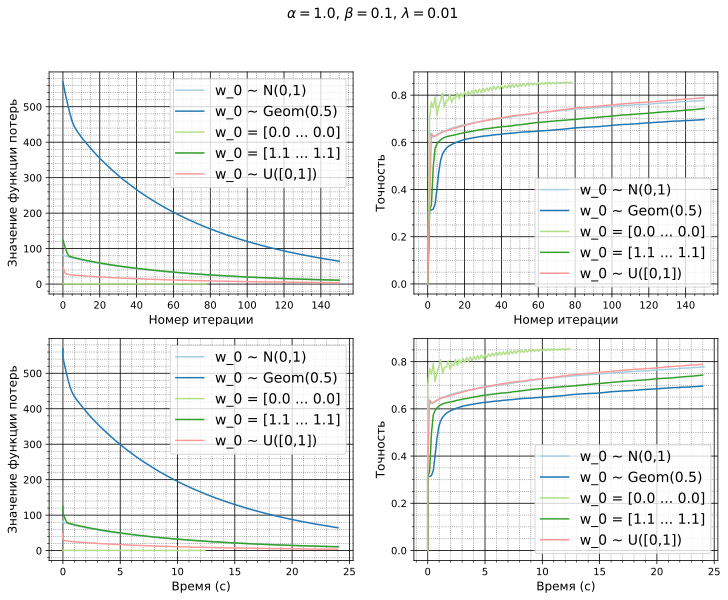

In [ ]:
fig = plt.figure(figsize=(12,9))
fig.suptitle(r'$\alpha=1.0$, $\beta=0.1$, $\lambda=0.01$', fontsize=14)
ax = fig.add_subplot(221)
plt.xlabel('Номер итерации', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(np.arange(len(value_w0_loss_time[i]['loss'])), value_w0_loss_time[i]['loss'], label=descript[i])
plt.legend(fontsize = 14)

ax = fig.add_subplot(222)
plt.xlabel('Номер итерации', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(np.arange(len(value_w0_loss_time[i]['accuracy'])), value_w0_loss_time[i]['accuracy'], label=descript[i])
plt.legend(fontsize = 14)

ax = fig.add_subplot(223)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(value_w0_loss_time[i]['time'], value_w0_loss_time[i]['loss'], label=descript[i])
plt.legend(fontsize = 14)

ax = fig.add_subplot(224)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(value_w0_loss_time[i]['time'], value_w0_loss_time[i]['accuracy'], label=descript[i])
plt.legend(fontsize = 14)
plt.savefig('g_w0_01_01_001.pdf')

# Исследование стохастического градиентного спуска

In [38]:
st_value_alpha_loss_time = list(range(6))
for i in range(6):
    st_value_alpha_loss_time[i] = {'loss':[], 'time':[], 'accuracy':[]}
    model = SGDClassifier(loss_function='binary_logistic', step_alpha=alphas[i], step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
    history_st = model.fit(X_train, y_train, X_test=X_test, y_test=y_test, trace=True, accur=True, log_freq=0.1)
    st_value_alpha_loss_time[i]['loss'] = copy(history_st['func'])
    st_value_alpha_loss_time[i]['time'] = copy(history_st['help_time'])
    st_value_alpha_loss_time[i]['accuracy'] = copy(history_st['accuracy'])
    st_value_alpha_loss_time[i]['epoch_num'] = copy(history_st['epoch_num'])

NameError: ignored

In [ ]:
fig = plt.figure(figsize=(15,10))
sns.set_palette("BrBG")
fig.suptitle(r'$\beta=0.5$, $\lambda=0.01, batch\_size=1000$', fontsize=14)
ax = fig.add_subplot(221)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_alpha_loss_time[i]['epoch_num'], st_value_alpha_loss_time[i]['loss'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(222)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_alpha_loss_time[i]['epoch_num'], st_value_alpha_loss_time[i]['accuracy'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(223)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5,-1,-1):
    plt.plot(st_value_alpha_loss_time[i]['time'], st_value_alpha_loss_time[i]['loss'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(224)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5, -1, -1):
    plt.plot(st_value_alpha_loss_time[i]['time'], st_value_alpha_loss_time[i]['accuracy'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)
plt.savefig('sg_alpha_05_001.pdf')

In [ ]:
fig = plt.figure(figsize=(15,10))
sns.set_palette("BrBG")
fig.suptitle(r'$\beta=0.5$, $\lambda=0.01, batch\_size=100$', fontsize=14)
ax = fig.add_subplot(221)
ax.set_ylim([0.4, 0.6])
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_alpha_loss_time[i]['epoch_num'], st_value_alpha_loss_time[i]['loss'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(222)
ax.set_ylim([0.78, 0.88])
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_alpha_loss_time[i]['epoch_num'], st_value_alpha_loss_time[i]['accuracy'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(223)
ax.set_ylim([0.4, 0.6])
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5,-1,-1):
    plt.plot(st_value_alpha_loss_time[i]['time'], st_value_alpha_loss_time[i]['loss'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(224)
ax.set_ylim([0.78, 0.88])
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5, -1, -1):
    plt.plot(st_value_alpha_loss_time[i]['time'], st_value_alpha_loss_time[i]['accuracy'], label='alpha = '+str(alphas[i]))
plt.legend(fontsize = 14)
plt.savefig('sg_alpha_05_001__.pdf')

In [ ]:
st_value_beta_loss_time = list(range(6))
for i in range(6):
    st_value_beta_loss_time[i] = {'loss':[], 'time':[], 'accuracy':[]}
    model = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=betas[i], tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
    st_history_beta = model.fit(X_train, y_train, X_test=X_test, y_test=y_test, trace=True, accur=True, log_freq=0.1)
    st_value_beta_loss_time[i]['loss'] = copy(st_history_beta['func'])
    st_value_beta_loss_time[i]['time'] = copy(st_history_beta['help_time'])
    st_value_beta_loss_time[i]['accuracy'] = copy(st_history_beta['accuracy'])
    st_value_beta_loss_time[i]['epoch_num'] = copy(st_history_beta['epoch_num'])


In [ ]:
fig = plt.figure(figsize=(15,10))
sns.set_palette("Paired")
fig.suptitle(r'$\alpha=1.0$, $\lambda=0.01, batch\_size=1000$', fontsize=14)
ax = fig.add_subplot(221)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_beta_loss_time[i]['epoch_num'], st_value_beta_loss_time[i]['loss'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(222)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_beta_loss_time[i]['epoch_num'], st_value_beta_loss_time[i]['accuracy'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(223)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_beta_loss_time[i]['time'], st_value_beta_loss_time[i]['loss'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(224)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_beta_loss_time[i]['time'], st_value_beta_loss_time[i]['accuracy'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)
plt.savefig('sg_beta_01_001.pdf', bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(15,10))
sns.set_palette("Paired")
fig.suptitle(r'$\alpha=1.0$, $\lambda=0.01, batch\_size=1000$', fontsize=14)
ax = fig.add_subplot(221)
ax.set_ylim([0.4, 0.6])
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_beta_loss_time[i]['epoch_num'], st_value_beta_loss_time[i]['loss'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(222)
ax.set_ylim([0.75, 0.875])
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_beta_loss_time[i]['epoch_num'], st_value_beta_loss_time[i]['accuracy'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(223)
ax.set_ylim([0.4, 0.6])
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_beta_loss_time[i]['time'], st_value_beta_loss_time[i]['loss'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(224)
ax.set_ylim([0.75, 0.875])
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(6):
    plt.plot(st_value_beta_loss_time[i]['time'], st_value_beta_loss_time[i]['accuracy'], label='beta = '+str(betas[i]))
plt.legend(fontsize = 14)
plt.savefig('sg_beta_01_001__.pdf', bbox_inches="tight")

In [ ]:
st_value_w0_loss_time = list(range(5))
for i in range(5):
    st_value_w0_loss_time[i] = {'loss':[], 'time':[], 'accuracy':[]}
    model = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
    st_history_w0 = model.fit(X_train, y_train, w_0=w0[i], X_test=X_test, y_test=y_test, trace=True, accur=True, log_freq=0.1)
    st_value_w0_loss_time[i]['loss'] = copy(st_history_w0['func'])
    st_value_w0_loss_time[i]['time'] = copy(st_history_w0['help_time'])
    st_value_w0_loss_time[i]['accuracy'] = copy(st_history_w0['accuracy'])
    st_value_w0_loss_time[i]['epoch_num'] = copy(st_history_w0['epoch_num'])

In [ ]:
fig = plt.figure(figsize=(12,9))
fig.suptitle(r'$\alpha=1.0$, $\beta=0.5$, $\lambda=0.01$, $batch\_size=1000$', fontsize=14)
ax = fig.add_subplot(221)
ax.set_ylim([-10,150])
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(st_value_w0_loss_time[i]['epoch_num'], st_value_w0_loss_time[i]['loss'], label=descript[i])
plt.legend(fontsize = 14)

ax = fig.add_subplot(222)
ax.set_ylim([0.65, 0.88])
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(st_value_w0_loss_time[i]['epoch_num'], st_value_w0_loss_time[i]['accuracy'], label=descript[i])
plt.legend(fontsize = 14)

ax = fig.add_subplot(223)
ax.set_ylim([-10,150])
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(st_value_w0_loss_time[i]['time'], st_value_w0_loss_time[i]['loss'], label=descript[i])
plt.legend(fontsize = 14)

ax = fig.add_subplot(224)
ax.set_ylim([0.65,0.88])
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(st_value_w0_loss_time[i]['time'], st_value_w0_loss_time[i]['accuracy'], label=descript[i])
plt.legend(fontsize = 14)
plt.savefig('sg_w0_01_01_001.pdf')

In [ ]:
batch_sizes = [100, 500, 1000, 5000, 10000]

In [ ]:
st_value_batch_loss_time = list(range(5))
for i in range(5):
    st_value_batch_loss_time[i] = {'loss':[], 'time':[], 'accuracy':[]}
    model = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=batch_sizes[i])
    st_history_batch = model.fit(X_train, y_train,X_test=X_test, y_test=y_test, trace=True, accur=True, log_freq=0.1)
    st_value_batch_loss_time[i]['time'] = st_history_batch['help_time']
    st_value_batch_loss_time[i]['loss'] = copy(st_history_batch['func'])
    st_value_batch_loss_time[i]['accuracy'] = copy(st_history_batch['accuracy'])
    st_value_batch_loss_time[i]['epoch_num'] = copy(st_history_batch['epoch_num'])

In [ ]:
print(st_history_batch['func'])

In [ ]:
fig = plt.figure(figsize=(12,9))
fig.suptitle(r'$\alpha=1.0$, $\beta=0.5$, $\lambda=0.01$', fontsize=14)
ax = fig.add_subplot(221)
ax.set_ylim([0.3,0.8])
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(st_value_batch_loss_time[i]['epoch_num'], st_value_batch_loss_time[i]['loss'], label='batch_size ='+str(batch_sizes[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(222)
ax.set_ylim([0.775, 0.875])
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(st_value_batch_loss_time[i]['epoch_num'], st_value_batch_loss_time[i]['accuracy'], label='batch_size =' + str(batch_sizes[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(223)
ax.set_ylim([0.3,0.8])
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(st_value_batch_loss_time[i]['time'], st_value_batch_loss_time[i]['loss'], label='batch_size =' + str(batch_sizes[i]))
plt.legend(fontsize = 14)

ax = fig.add_subplot(224)
ax.set_ylim([0.775,0.875])
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(5):
    plt.plot(st_value_batch_loss_time[i]['time'], st_value_batch_loss_time[i]['accuracy'], label='batch_size =' + str(batch_sizes[i]))
plt.legend(fontsize = 14)
plt.savefig('sg_batch_01_01_001.pdf')

# Сравнение стохастического и градиентного спусков

In [ ]:
gd = GDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01)
hist_gd = gd.fit(X_train, y_train, X_test=X_test, y_test=y_test, trace=True, accur=True)

In [ ]:
sgd = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
hist_sgd = sgd.fit(X_train, y_train,X_test=X_test, y_test=y_test, trace=True, accur=True, log_freq=0.1)

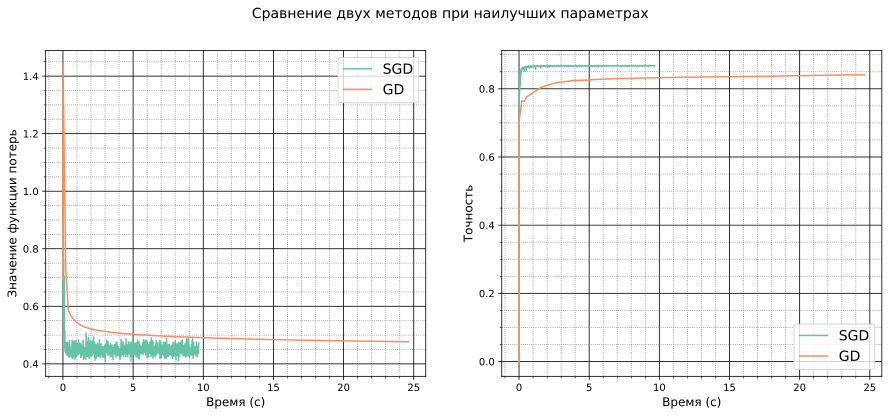

In [ ]:
fig = plt.figure(figsize=(15,6))
sns.set_palette("Set2")
fig.suptitle('Сравнение двух методов при наилучших параметрах', fontsize=14)


ax = fig.add_subplot(121)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(hist_sgd['help_time'], hist_sgd['func'], label='SGD')
plt.plot(hist_gd['help_time'], hist_gd['func'], label='GD')

plt.legend(fontsize = 14)

ax = fig.add_subplot(122)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(hist_sgd['help_time'], hist_sgd['accuracy'], label='SGD')
plt.plot(hist_gd['help_time'], hist_gd['accuracy'], label='GD')

plt.legend(fontsize = 14)
plt.savefig('compare1.pdf', bbox_inches="tight")

# Лемматизация

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
stop = stopwords.words("english")

In [10]:
lemX_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_train.csv')
lemX_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_test.csv')

In [11]:
lemX_train['comment_text'] = lemX_train['comment_text'].apply(lambda s: s.lower())
lemX_test['comment_text'] = lemX_test['comment_text'].apply(lambda s: s.lower())

In [12]:
lemX_train['comment_text'] = lemX_train['comment_text'].apply(lambda s: re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', s))
lemX_test['comment_text'] = lemX_test['comment_text'].apply(lambda s: re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', s))

In [13]:
lem = WordNetLemmatizer()

In [14]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [15]:
lemX_train['comment_text'] = lemX_train['comment_text'].apply(lambda s: ' '.join(lem.lemmatize(word) for word in s.split() if word not in stop))
lemX_test['comment_text'] = lemX_test['comment_text'].apply(lambda s: ' '.join(lem.lemmatize(word) for word in s.split() if word not in stop))

In [16]:
lemy_train = copy(lemX_train['is_toxic'])
lemX_train = lemX_train.drop('is_toxic', axis=1)
lemy_test = copy(lemX_test['is_toxic'])
lemX_test = lemX_test.drop('is_toxic', axis=1)

In [ ]:
cv = CountVectorizer(min_df=0.0001)
lemX_train = cv.fit_transform(lemX_train['comment_text'])
lemX_test = cv.transform(lemX_test['comment_text'])

In [ ]:
lemx_train, lemx_test, lem_y_train, lem_y_test = train_test_split(lemX_train, lemy_train, test_size=0.3, random_state=10)

In [18]:
lem_y_train = lem_y_train.values.astype(int) * 2 - 1
lem_y_test = lem_y_test.values.astype(int) * 2 - 1

NameError: ignored

In [ ]:
X_train.shape, lemx_train.shape

((36442, 16050), (36442, 14308))

In [191]:
lem_gd = GDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01)
lem_hist_gd = lem_gd.fit(lemx_train, lem_y_train, X_test=lemx_test, y_test=lem_y_test, trace=True, accur=True)

In [192]:
lem_sgd = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
lem_hist_sgd = lem_sgd.fit(lemx_train, lem_y_train,X_test=lemx_test, y_test=lem_y_test, trace=True, accur=True, log_freq=0.1)

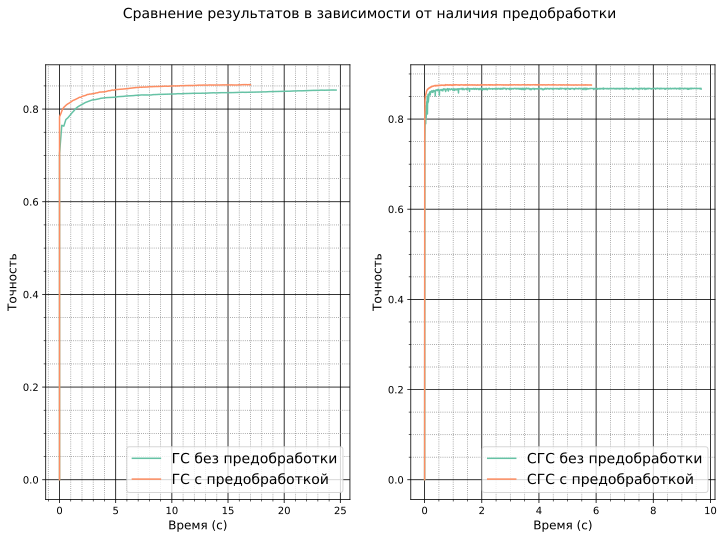

In [193]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Сравнение результатов в зависимости от наличия предобработки', fontsize=14)

ax = fig.add_subplot(121)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(hist_gd['help_time'], hist_gd['accuracy'], label='ГС без предобработки')
plt.plot(lem_hist_gd['help_time'], lem_hist_gd['accuracy'], label='ГС с предобработкой')
plt.legend(fontsize = 14)

ax = fig.add_subplot(122)
plt.xlabel('Время (с)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(hist_sgd['help_time'], hist_sgd['accuracy'], label='СГС без предобработки')
plt.plot(lem_hist_sgd['help_time'], lem_hist_sgd['accuracy'], label='СГС с предобработкой')
plt.legend(fontsize = 14)
plt.savefig('compare_lemat.pdf', bbox_inches="tight")

In [195]:
print("GD:", hist_gd['accuracy'][-1], lem_hist_gd['accuracy'][-1])

GD: 0.8410269543504706 0.8524873551443755


In [ ]:
print("SGD:", hist_sgd['accuracy'][-1], lem_hist_sgd['accuracy'][-1])

SGD: 0.8665087393559127 0.8754081567321852


# Tfidf и BOW

In [21]:
max_df = [0.9, 0.99, 0.999]
min_df = [0.01, 0.001, 0.0001]

In [ ]:
dim = {"bow": [[0,0,0], [0,0,0],[0,0,0]], "tfidf": [[0,0,0], [0,0,0],[0,0,0]]}
acc = {"bow": [[0,0,0], [0,0,0],[0,0,0]], "tfidf": [[0,0,0], [0,0,0],[0,0,0]]}

In [ ]:
cur_X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_train.csv')
cur_X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_test.csv')

In [ ]:
cur_X_train['comment_text'] = cur_X_train['comment_text'].apply(lambda s: s.lower())
cur_X_test['comment_text'] = cur_X_test['comment_text'].apply(lambda s: s.lower())

In [ ]:
cur_X_train['comment_text'] = cur_X_train['comment_text'].apply(lambda s: re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', s))
cur_X_test['comment_text'] = cur_X_test['comment_text'].apply(lambda s: re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', s))

In [ ]:
cur_y_train = copy(cur_X_train['is_toxic'])
cur_X_train = cur_X_train.drop('is_toxic', axis=1)

In [ ]:
cur_y_train = cur_y_train.values.astype(int) * 2 - 1

In [196]:
for i in range(3):
    for j in range(3):
        tmp_X = copy(lemX_train)
        ccv = CountVectorizer(min_df=min_df[i], max_df=max_df[j])
        tmp_X = ccv.fit_transform(tmp_X['comment_text'])
        tx_train, tx_test, ty_train, ty_test = train_test_split(tmp_X, lemy_train, test_size=0.3, random_state=10)
        dim['bow'][i][j] = copy(tx_train.shape[1])
        cur_gd = GDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01)
        cur_hist_gd = cur_gd.fit(tx_train, ty_train, X_test=tx_test, y_test=ty_test, trace=True, accur=True)
        cur_sgd = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
        cur_hist_sgd = cur_sgd.fit(tx_train, ty_train, X_test=tx_test, y_test=ty_test, trace=True, accur=True, log_freq=0.1)
        acc['bow'][i][j] = copy((cur_hist_gd['accuracy'][-1], cur_hist_sgd['accuracy'][-1]))

In [197]:
dim['bow']

[[568, 568, 568], [3736, 3736, 3736], [16050, 16050, 16050]]

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [198]:
for i in range(3):
    for j in range(3):
        tmp_X = copy(cur_X_train)
        idf = TfidfVectorizer(min_df=min_df[i], max_df=max_df[j])
        tmp_X = idf.fit_transform(tmp_X['comment_text'])
        tx_train, tx_test, ty_train, ty_test = train_test_split(tmp_X, cur_y_train, test_size=0.3, random_state=10)
        dim['tfidf'][i][j] = copy(tx_train.shape[1])
        cur_gd = GDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01)
        cur_hist_gd = cur_gd.fit(tx_train, ty_train, X_test=tx_test, y_test=ty_test, trace=True, accur=True)
        cur_sgd = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
        cur_hist_sgd = cur_sgd.fit(tx_train, ty_train, X_test=tx_test, y_test=ty_test, trace=True, accur=True, log_freq=0.1)
        acc['tfidf'][i][j] = copy((cur_hist_gd['accuracy'][-1], cur_hist_sgd['accuracy'][-1]))

In [199]:
dim['tfidf']

[[568, 568, 568], [3736, 3736, 3736], [16050, 16050, 16050]]

In [200]:
acc['bow']

[[(0.8296946027274473, 0.849606248799539),
  (0.8302067994109739, 0.849606248799539),
  (0.8302067994109739, 0.849606248799539)],
 [(0.8403867084960625, 0.8664447147704719),
  (0.8400665855688585, 0.8664447147704719),
  (0.8400665855688585, 0.8664447147704719)],
 [(0.8412830526922338, 0.8665087393559127),
  (0.8410909789359113, 0.8665087393559127),
  (0.8410909789359113, 0.8665087393559127)]]

In [201]:
acc['tfidf']

[[(0.7272552660221525, 0.7799474998399385),
  (0.7284077085600871, 0.7799474998399385),
  (0.7284077085600871, 0.7799474998399385)],
 [(0.7251424547026059, 0.7704718611946988),
  (0.7251424547026059, 0.7704718611946988),
  (0.7251424547026059, 0.7704718611946988)],
 [(0.7229015942121775, 0.7633011076253281),
  (0.7229015942121775, 0.7633011076253281),
  (0.7229015942121775, 0.7633011076253281)]]

In [17]:
lem_dim = {"bow": [[0,0,0], [0,0,0],[0,0,0]], "tfidf": [[0,0,0], [0,0,0],[0,0,0]]}
lem_acc = {"bow": [[0,0,0], [0,0,0],[0,0,0]], "tfidf": [[0,0,0], [0,0,0],[0,0,0]]}

In [19]:
lemy_train = lemy_train.values.astype(int) * 2 - 1
lemy_test = lemy_test.values.astype(int) * 2 - 1

In [30]:
for i in range(3):
    for j in range(3):
        tmp_X = copy(lemX_train)
        ccv = CountVectorizer(min_df=min_df[i], max_df=max_df[j])
        tmp_X = ccv.fit_transform(tmp_X['comment_text'])
        tx_train, tx_test, ty_train, ty_test = train_test_split(tmp_X, lemy_train, test_size=0.3, random_state=10)
        lem_dim['bow'][i][j] = copy(tx_train.shape[1])
        cur_gd = GDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01)
        cur_hist_gd = cur_gd.fit(tx_train, ty_train, X_test=tx_test, y_test=ty_test, trace=True, accur=True)
        cur_sgd = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
        cur_hist_sgd = cur_sgd.fit(tx_train, ty_train, X_test=tx_test, y_test=ty_test, trace=True, accur=True, log_freq=0.1)
        lem_acc['bow'][i][j] = copy((cur_hist_gd['accuracy'][-1], cur_hist_sgd['accuracy'][-1]))

In [31]:
lem_dim['bow']

[[456, 456, 456], [3400, 3400, 3400], [14308, 14308, 14308]]

In [32]:
lem_acc['bow']

[[(0.8245086113067418, 0.8385940201037199),
  (0.823100070427044, 0.8385940201037199),
  (0.823100070427044, 0.8385940201037199)],
 [(0.8510147896792368, 0.8737435175107241),
  (0.8508227159229144, 0.8737435175107241),
  (0.8508227159229144, 0.8737435175107241)],
 [(0.8526154043152571, 0.8754081567321852),
  (0.8526794289006979, 0.8754081567321852),
  (0.8526794289006979, 0.8754081567321852)]]

In [35]:
for i in range(3):
    for j in range(3):
        tmp_X = copy(lemX_train)
        idf = TfidfVectorizer(min_df=min_df[i], max_df=max_df[j])
        tmp_X = idf.fit_transform(tmp_X['comment_text'])
        tx_train, tx_test, ty_train, ty_test = train_test_split(tmp_X, lemy_train, test_size=0.3, random_state=10)
        lem_dim['tfidf'][i][j] = copy(tx_train.shape[1])
        cur_gd = GDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01)
        cur_hist_gd = cur_gd.fit(tx_train, ty_train, X_test=tx_test, y_test=ty_test, trace=True, accur=True)
        cur_sgd = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
        cur_hist_sgd = cur_sgd.fit(tx_train, ty_train, X_test=tx_test, y_test=ty_test, trace=True, accur=True, log_freq=0.1)
        lem_acc['tfidf'][i][j] = copy((cur_hist_gd['accuracy'][-1], cur_hist_sgd['accuracy'][-1]))

In [36]:
lem_dim['tfidf']

[[456, 456, 456], [3400, 3400, 3400], [14308, 14308, 14308]]

In [37]:
lem_acc['tfidf']

[[(0.7763621230552532, 0.8000512196683527),
  (0.777130418080543, 0.8000512196683527),
  (0.777130418080543, 0.8000512196683527)],
 [(0.7928164415135412, 0.8111274729496126),
  (0.7931365644407452, 0.8111274729496126),
  (0.7931365644407452, 0.8111274729496126)],
 [(0.7944810807350022, 0.8099750304116781),
  (0.7945451053204431, 0.8099750304116781),
  (0.7945451053204431, 0.8099750304116781)]]

# Алгоритм для тестовой выборки

In [ ]:
last_X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_train.csv')
last_X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_test.csv')

In [ ]:
last_X_train['comment_text'] = last_X_train['comment_text'].apply(lambda s: s.lower())
last_X_test['comment_text'] = last_X_test['comment_text'].apply(lambda s: s.lower())

In [ ]:
last_X_train['comment_text'] = last_X_train['comment_text'].apply(lambda s: re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', s))
last_X_test['comment_text'] = last_X_test['comment_text'].apply(lambda s: re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', s))

In [ ]:
last_X_train['comment_text'] = last_X_train['comment_text'].apply(lambda s: ' '.join(lem.lemmatize(word) for word in s.split() if word not in stop))
last_X_test['comment_text'] = last_X_test['comment_text'].apply(lambda s: ' '.join(lem.lemmatize(word) for word in s.split() if word not in stop))

In [ ]:
last_y_train = copy(last_X_train['is_toxic'])
last_X_train = last_X_train.drop('is_toxic', axis=1)
last_y_test = copy(last_X_test['is_toxic'])
last_X_test = last_X_test.drop('is_toxic', axis=1)

In [ ]:
cv_last = CountVectorizer(min_df=0.0001)
last_X_train = cv.fit_transform(last_X_train['comment_text'])
last_X_test = cv.transform(last_X_test['comment_text'])

In [ ]:
lastx_train, lastx_test, lasty_train, lasty_test = train_test_split(last_X_train, last_y_train, test_size=0.3, random_state=10)

In [ ]:
lasty_train = lasty_train.values.astype(int) * 2 - 1
lasty_test = lasty_test.values.astype(int) * 2 - 1

In [ ]:
lambdas = [0.0, 0.01, 0.05, 0.1, 0.5, 0.8, 1]

In [202]:
for l in lambdas:
    last_sgd = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=l, batch_size=1000)
    last_hist_sgd = copy(last_sgd.fit(lastx_train, lasty_train,X_test=lastx_test, y_test=lasty_test, trace=True, accur=True, log_freq=0.01))
    print(last_hist_sgd['accuracy'][-1])

0.8957039503169217
0.8757282796593892
0.8535757730968692
0.8411550035213522
0.8021000064024586
0.8008835392790832
0.7842371470644728


In [203]:
last_sgd = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.001, batch_size=1000)
last_hist_sgd = copy(last_sgd.fit(lastx_train, lasty_train,X_test=lastx_test, y_test=lasty_test, trace=True, accur=True, log_freq=0.01))
print(last_hist_sgd['accuracy'][-1])

0.892566745630322


In [ ]:
last_y_train = last_y_train.values.astype(int) * 2 - 1

In [ ]:
last_y_test = last_y_test.values.astype(int) * 2 - 1

In [204]:
final_model = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
final_model.fit(last_X_train, last_y_train)

In [ ]:
pred = final_model.predict(last_X_test)

In [ ]:
accuracy(pred, last_y_test)

0.855823176629909

In [ ]:
fin_X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_test.csv')

In [ ]:
fin_X_test['comment_text'] = fin_X_test['comment_text'].apply(lambda s: s.lower())
fin_X_test['comment_text'] = fin_X_test['comment_text'].apply(lambda s: re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', s))
fin_X_test['comment_text'] = fin_X_test['comment_text'].apply(lambda s: ' '.join(lem.lemmatize(word) for word in s.split() if word not in stop))

In [ ]:
fin_X_test['comment_text'].values[pred != last_y_test][0:10]

array(['dear god site horrible',
       'arab committing genocide iraq protest europe may europe also burn hell',
       'jew race get mother mention ethiopian jew testing jew prof well fact accept convert',
       '', 'puwersa ng masa',
       'dare vandalize page hm beagle vandalize demon',
       'aapn bhtla aanand jhala',
       'avg plenty greek love king stop acting like greek hate parrot government tell u via medium greek asked george king supported reclaimed much land voted keep numerous time 1930 97 vote also tried overthrow dictator read book greek government biggest liar u want u king claim constantinople asia minor direct descendant five greek imperial byzantine dynasty monomachos comnenos laskaris angelos paleologos',
       'bizarre ani medjool abuse wikipedia rule get rewarded award barnstar wtf anyhow new person adept ridicule joined conversation falafel sigh',
       'black mamba ponious snake word kill many people king cobra kill many people india'],
      dtype=objec

In [220]:
pred[:10]

array([-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [224]:
ind = np.where(pred != last_y_test)

In [225]:
ind

(array([    1,     8,    12, ..., 20670, 20673, 20674]),)

In [227]:
for i in range(20):
  print("pred =", pred[ind[0][i]], "obj =", fin_X_test['comment_text'].values[ind[0][i]])

pred = 1.0 obj = dear god site horrible
pred = -1.0 obj = arab committing genocide iraq protest europe may europe also burn hell
pred = 1.0 obj = jew race get mother mention ethiopian jew testing jew prof well fact accept convert
pred = 1.0 obj = 
pred = 1.0 obj = puwersa ng masa
pred = -1.0 obj = dare vandalize page hm beagle vandalize demon
pred = 1.0 obj = aapn bhtla aanand jhala
pred = 1.0 obj = avg plenty greek love king stop acting like greek hate parrot government tell u via medium greek asked george king supported reclaimed much land voted keep numerous time 1930 97 vote also tried overthrow dictator read book greek government biggest liar u want u king claim constantinople asia minor direct descendant five greek imperial byzantine dynasty monomachos comnenos laskaris angelos paleologos
pred = 1.0 obj = bizarre ani medjool abuse wikipedia rule get rewarded award barnstar wtf anyhow new person adept ridicule joined conversation falafel sigh
pred = 1.0 obj = black mamba ponious s

# n-граммы

In [ ]:
ngrams = {'time': [], 'accuracy': []}

In [205]:
for n in range(1, 11):
    tmp_X = copy(cur_X_train)
    idf = TfidfVectorizer(min_df=0.0001, ngram_range=(n,n))
    tmp_X = idf.fit_transform(tmp_X['comment_text'])
    tx_train, tx_test, ty_train, ty_test = train_test_split(tmp_X, cur_y_train, test_size=0.3, random_state=10)
    cur_sgd = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
    cur_hist_sgd = cur_sgd.fit(tx_train, ty_train, X_test=tx_test, y_test=ty_test, trace=True, accur=True, log_freq=0.1)
    ngrams['time'].append(cur_hist_sgd['help_time'][-1])
    ngrams['accuracy'].append(cur_hist_sgd['accuracy'][-1])

In [208]:
ngrams['time']

[9.075495719909668,
 4.394582509994507,
 1.3958735466003418,
 2.1378984451293945,
 2.7003965377807617,
 3.232055902481079,
 4.264947175979614,
 6.23701548576355,
 2.7677690982818604,
 5.408435821533203]

In [211]:
ngrams['accuracy']

[0.7633011076253281,
 0.7752096805173186,
 0.7574748703502144,
 0.6611818938472374,
 0.5602151226070812,
 0.5275625840322684,
 0.5278186823740316,
 0.5230168384659709,
 0.5153979127985147,
 0.523657084320379]

In [212]:
for i in range(1,5):
    for j in range(i, 5):
        tmp_X = copy(cur_X_train)
        idf = TfidfVectorizer(min_df=0.0001, ngram_range=(i,j))
        tmp_X = idf.fit_transform(tmp_X['comment_text'])
        tx_train, tx_test, ty_train, ty_test = train_test_split(tmp_X, cur_y_train, test_size=0.3, random_state=10)
        cur_sgd = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
        cur_hist_sgd = cur_sgd.fit(tx_train, ty_train, X_test=tx_test, y_test=ty_test, trace=True, accur=True, log_freq=0.1)
        print('(', i, j, '): time =', cur_hist_sgd['help_time'][-1], ', acc =', cur_hist_sgd['accuracy'][-1])

( 1 1 ): time = 8.410593509674072 , acc = 0.7633011076253281
( 1 2 ): time = 13.625802278518677 , acc = 0.7501760676099622
( 1 3 ): time = 16.094751358032227 , acc = 0.748575452973942
( 1 4 ): time = 17.02052116394043 , acc = 0.7487675267302645
( 2 2 ): time = 3.802828550338745 , acc = 0.7752096805173186
( 2 3 ): time = 3.140514373779297 , acc = 0.777130418080543
( 2 4 ): time = 4.007764577865601 , acc = 0.7775785901786286
( 3 3 ): time = 1.2770850658416748 , acc = 0.7574748703502144
( 3 4 ): time = 1.6244862079620361 , acc = 0.7557462065433126
( 4 4 ): time = 2.049116849899292 , acc = 0.6611818938472374


In [213]:
lem_ngrams = {'time': [], 'accuracy': []}

In [214]:
lemgram_X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_train.csv')
lemgram_X_train['comment_text'] = lemgram_X_train['comment_text'].apply(lambda s: s.lower())
lemgram_X_train['comment_text'] = lemgram_X_train['comment_text'].apply(lambda s: re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', s))

In [215]:
lemgram_X_train['comment_text'] = lemgram_X_train['comment_text'].apply(lambda s: ' '.join(lem.lemmatize(word) for word in s.split() if word not in stop))

In [216]:
lemgram_y_train = copy(lemgram_X_train['is_toxic'])
lemgram_X_train = lemgram_X_train.drop('is_toxic', axis=1)

In [217]:
legram_y_train = lemgram_y_train.values.astype(int) * 2 - 1

In [29]:
for n in range(1, 11):
    tmp_X = copy(lemgram_X_train)
    idf = TfidfVectorizer(min_df=0.0001, ngram_range=(n,n))
    tmp_X = idf.fit_transform(tmp_X['comment_text'])
    tx_train, tx_test, ty_train, ty_test = train_test_split(tmp_X, lemgram_y_train, test_size=0.3, random_state=10)
    cur_sgd = SGDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.5, tolerance=1e-4, max_iter=150, l2_coef=0.01, batch_size=1000)
    cur_hist_sgd = cur_sgd.fit(tx_train, ty_train, X_test=tx_test, y_test=ty_test, trace=True, accur=True, log_freq=0.1)
    lem_ngrams['time'].append(cur_hist_sgd['help_time'][-1])
    lem_ngrams['accuracy'].append(cur_hist_sgd['accuracy'][-1])

NameError: ignored